In [1]:
import os
import re
import math
import gzip
import spacy
import urllib
import string
import pickle
import tarfile
import requests
import itertools
import collections
import pandas as pd
import pandas as pd
import numpy as np
from utils.plot_processing import extract_word_frequency
from wordcloud import WordCloud
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve

%matplotlib inline

In [2]:
cmu_path = "data/MovieSummaries/"
corenlp_path = "data/CoreNLP/"
summary_raw_path = corenlp_path + "corenlp_plot_summaries/"
summary_path = corenlp_path + "corenlp_plot_summaries_xml/"
movies_path = cmu_path + "movie.metadata.tsv"
characters_path = cmu_path + "character.metadata.tsv"
plot_path = cmu_path + "plot_summaries.txt"
gender_dict_path = "data/gender_dict.pkl"

In [3]:
if not os.path.exists(movies_path):
    movie_url = "http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz"
    tar_file = tarfile.open(fileobj=urllib.request.urlopen(movie_url), mode="r:gz")
    tar_file.extractall(path=movies_path)
    tar_file.close()

In [4]:
if not os.path.exists(corenlp_path):
    corenlp_url = "http://www.cs.cmu.edu/~ark/personas/data/corenlp_plot_summaries.tar"
    tar_file = tarfile.open(fileobj=urllib.request.urlopen(corenlp_url), mode="r|")
    tar_file.extractall(path=corenlp_path)

    os.mkdir(summary_path)
    for filename in os.listdir(summary_raw_path):
        f = os.path.join(summary_raw_path, filename)
        if os.path.isfile(f):
            with gzip.open(f, "rb") as f_in:
                gz_file = os.path.join(summary_path, filename)
                with open(gz_file[:-3], "wb") as f_out:
                    f_out.write(f_in.read())
    tar_file.close()

In [5]:
movies_column_names = [
    "wikipedia_id",
    "freebase_id",
    "name",
    "release_date",
    "box_office_revenue",
    "runtime",
    "languages",
    "countries",
    "genres",
]

characters_column_names = [
    "wikipedia_id",
    "freebase_id",
    "release_date",
    "character_name",
    "actor_dob",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age",
    "freebase_character_map",
    "freebase_character_id",
    "freebase_actor_id",
]

plot_column_names = ["wikipedia_id", "summary"]

movies = pd.read_csv(movies_path, sep="\t", header=None, names=movies_column_names)
characters = pd.read_csv(
    characters_path, sep="\t", header=None, names=characters_column_names
)
plots = pd.read_csv(plot_path, sep="\t", header=None, names=plot_column_names)

In [6]:
movies = movies.dropna(subset=['release_date'])

print("{} movies left (81741 before).".format(len(movies)))
movies.head()

74839 movies left (81741 before).


,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [7]:
def extract_year(x):
    return str(x)[:4]


movies.release_date = movies.release_date.apply(extract_year)
characters.release_date = characters.release_date.apply(extract_year)

In [8]:
movies[movies.release_date == "1010"]

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
62836,29666067,/m/0fphzrf,Hunting Season,1010,12160978.0,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My..."


In [9]:
movies.release_date = movies.release_date.apply(lambda x: "2010" if x == "1010" else x)
characters.release_date = characters.release_date.apply(
    lambda x: "2010" if x == "1010" else x
)

In [10]:
get_dict_keys = (
    lambda x: np.nan
    if x == {}
    else [re.sub(r"\x20[Ll]anguage", "", w) for w in re.findall(r'"(.*?)"', x)[1::2]]
)
movies.countries = movies.countries.apply(get_dict_keys)
movies.languages = movies.languages.apply(get_dict_keys)
movies.genres = movies.genres.apply(get_dict_keys)

In [11]:
movies_plots = pd.merge(movies, plots, on="wikipedia_id", how="inner")[
    ["wikipedia_id", "release_date", "languages", "countries", "genres", "summary"]
]
movies_plots.head()

,wikipedia_id,release_date,languages,countries,genres,summary
0,975900,2001,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,1987,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
2,261236,1983,[German],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."
3,18998739,2002,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
4,6631279,1997,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."


In [12]:
characters_filtered = characters.dropna(subset=["character_name", "actor_gender"])
characters_filtered.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [13]:
temp_df = movies_plots[movies_plots.wikipedia_id.isin(characters_filtered.wikipedia_id)]

In [14]:
index = []
name_gender = []
count_gender = {"M": 0, "F": 0}
for i in range(len(temp_df)):
    temp_name_gender = {}
    flag = 0
    filtered = characters_filtered[
        characters_filtered.wikipedia_id == temp_df.iloc[i].wikipedia_id
    ]
    for word, gender in zip(
        filtered.character_name.apply(str.lower), filtered.actor_gender
    ):
        if (
            word in temp_df.iloc[i].summary.lower()
        ):  # only consider full match. i.e. full character name matches with the plot summary.
            if (
                flag == 0
            ):  # if there's one full match in the plot summary, we keep this movie.
                index.append(i)
                flag = 1
            temp_name_gender[word] = gender
            count_gender[gender] += 1
    if flag == 1:
        name_gender.append(temp_name_gender)

assert len(name_gender) == len(index)

In [15]:
movies_plots_filtered = temp_df.iloc[index].copy()
movies_plots_filtered.loc[:, "character_names"] = name_gender
movies_plots_filtered = movies_plots_filtered.reset_index(drop=True)
movies_plots_filtered.head()

,wikipedia_id,release_date,languages,countries,genres,summary,character_names
0,975900,2001,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",{'desolation williams': 'M'}
1,18998739,2002,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...",{'morgana': 'F'}
2,6631279,1997,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...","{'rebecca': 'F', 'nina': 'F'}"
3,171005,1989,[English],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,{'henry v': 'M'}
4,77856,1964,[English],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",The film opens with Mary Poppins perched in a...,"{'george banks': 'M', 'bert': 'M', 'mary poppi..."


In [16]:
# for each gender, compute word frequency dictionary on all words/nouns/verbs/adjectives.
gender_dict = {
    "M": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
    "F": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
}

# keep these POSs and map POS to verbs/nouns/adjectives
pos_mapping = {
    "JJ": "adj", "JJR": "adj", "JJS": "adj",                                                    # adjectives
    "NN": "noun", "NNS": "noun", "NNP": "noun", "NNPS": "noun",                                 # nouns
    "VB": "verb", "VBD": "verb", "VBG": "verb", "VBN": "verb", "VBP": "verb", "VBZ": "verb",    # verbs
}

window_size = 2  # search two words of {n., adj., v.} before first name and after last name if possible.

In [17]:
if not os.path.exists(gender_dict_path):
    # compute the word frequency of different word types
    gender_dict = extract_word_frequency(movies_plots_filtered, gender_dict, pos_mapping, summary_path, window_size=window_size)

    # create a binary pickle file 
    with open(gender_dict_path, "wb") as f:
        # write the python object (dict) to pickle file
        pickle.dump(gender_dict, f)

else:
    with open(gender_dict_path, "rb") as f:
        gender_dict = pickle.load(f)

## Gender stereotype analysis on movie plot summaries

Now we want to know whether gender stereotypes exist in movie plot summaries. We define gender stereotypes as the distribution difference of the words describing male and female characters in the movie plot summaries. We consider relevant words around male characters and female characters. We implement this by searching plot summaries containing character names in the `character` dataframe. Then we identify relevant words as first or last two words of noun, verb, or adjective from the character name within one sentence. We extract relevant words around these names by gender and count log frequency of words related to different genders. Finally we analyze top 15 frequent words for different genders.

### Stopwords Removal

There are so many stopwords like "be", "have", etc. We want to remove them.

In [18]:
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
spacy_stopwords.add("s")

In [19]:
for gender, inner_dict in gender_dict.items():
    for word_type, freq_dict in inner_dict.items():
        for stopword in spacy_stopwords:
                freq_dict.pop(stopword.lower(), None)

### Overall Analysis



We first analyze the overall distribution of relevant words of male and female characters. Then we compare log frequencies of different POS of the words (noun, verb, adjective) between men and women.

We compare the frequency difference. (M-F), 正值最大: male-distinguishable; 负值最大: female-distinguishable.

In [39]:
male_dict = {}
female_dict = {}
diff_dict = {}

for idx, word_type in enumerate(["all", "noun", "verb", "adj"]):
    male_words = pd.DataFrame.from_dict(
        gender_dict["M"][word_type], orient="index", columns=["count"]
    ).sort_values(by=["count"])
    male_words["freq"] = male_words["count"] / male_words["count"].sum()  # compute frequency
    male_dict[word_type] = male_words

    female_words = pd.DataFrame.from_dict(
        gender_dict["F"][word_type], orient="index", columns=["count"]
    ).sort_values(by=["count"])
    female_words["freq"] = female_words["count"] / female_words["count"].sum()
    female_dict[word_type] = female_words

    diff_words = (male_words-female_words)["freq"]
    diff_dict[word_type] = diff_words

In [55]:
tmp = pd.concat([male_words, female_words], axis=1)
tmp.columns = ["count_m", "freq_m", "count_f", "freq_f"]
tmp[~tmp.isnull().any(axis=1)]

,count_m,freq_m,count_f,freq_f
chauvinistic,1.0,0.000036,1.0,0.000070
pannalal,1.0,0.000036,1.0,0.000070
olivia,1.0,0.000036,1.0,0.000070
=,1.0,0.000036,2.0,0.000140
brainwashed,1.0,0.000036,5.0,0.000351
...,...,...,...,...
best,306.0,0.011114,187.0,0.013110
old,388.0,0.014093,205.0,0.014372
dead,411.0,0.014928,194.0,0.013601
young,514.0,0.018669,274.0,0.019209


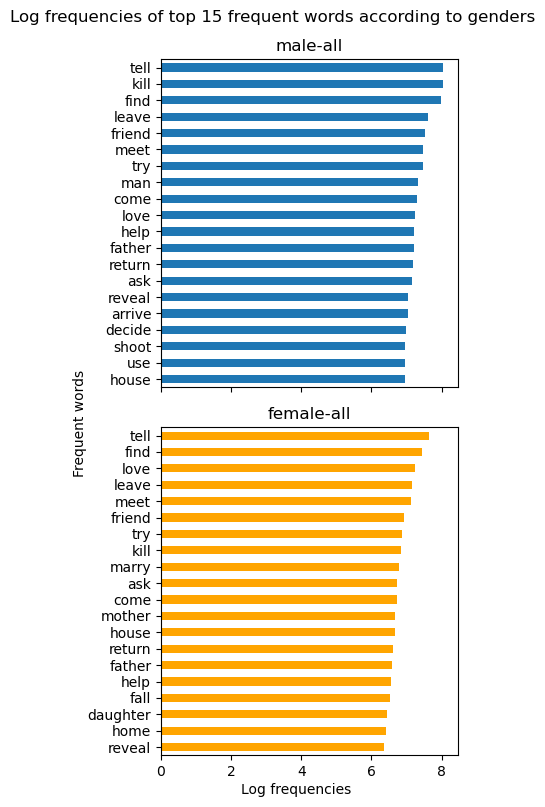

In [34]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(4, 8))
axes = axes.ravel()
fig.suptitle(
    "Log frequencies of top 15 frequent words according to genders"
)

for idx, word_type in enumerate(["all"]):

    ax = np.log(male_dict[word_type]["count"][-20:]).plot.barh(
        ax=axes[idx], legend=False, title="male-{}".format(word_type)
    )
    ax = np.log(female_dict[word_type]["count"][-20:]).plot.barh(
        ax=axes[idx + 1],
        color="orange",
        legend=False,
        title="female-{}".format(word_type),
    )

fig.text(0.42, 0, "Log frequencies")
fig.text(0, 0.4, "Frequent words", rotation=90)
plt.tight_layout()
plt.show()

这个表的效果并不好, 因为有太多词男女通用了, 而且很高频. 真正要研究不一样的. 根据 feedback 选择求 frequency difference. 然后排序最正的 (male bias) 和最负的 (female bias).

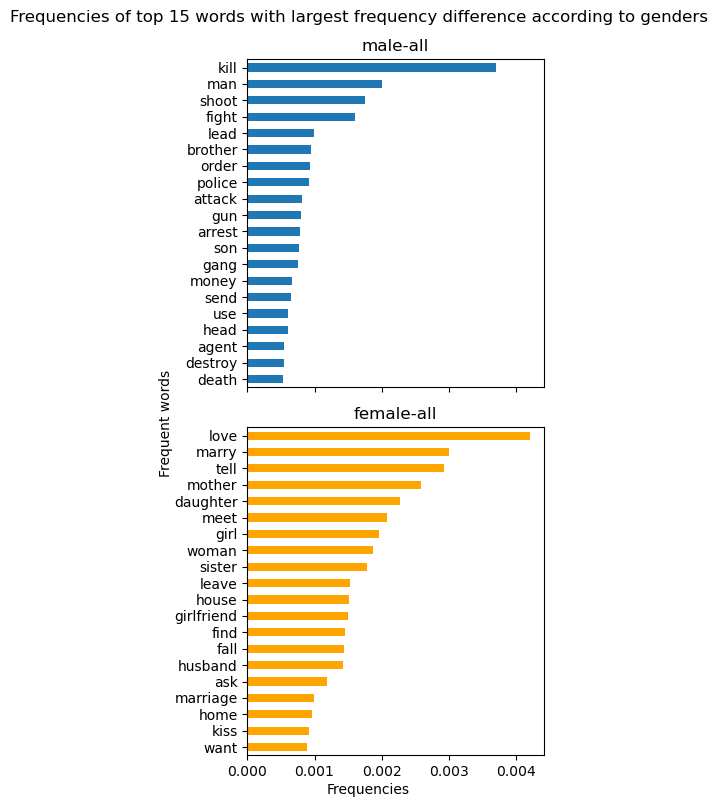

In [33]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(4, 8))
axes = axes.ravel()
fig.suptitle(
    "Frequencies of top 15 words with largest frequency difference according to genders"
)

for idx, word_type in enumerate(["all"]):
    male_words = diff_dict["all"].dropna().sort_values()[-20:]
    female_words = diff_dict["all"].dropna().sort_values(ascending=False)[-20:].apply(np.abs)
    ax = male_words.plot.barh(
        ax=axes[idx], legend=False, title="male-{}".format(word_type)
    )
    ax = female_words.plot.barh(
        ax=axes[idx + 1],
        color="orange",
        legend=False,
        title="female-{}".format(word_type),
    )

fig.text(0.42, 0, "Frequencies")
fig.text(0, 0.4, "Frequent words", rotation=90)
plt.tight_layout()
plt.show()

这就很直观了.

### Different POS

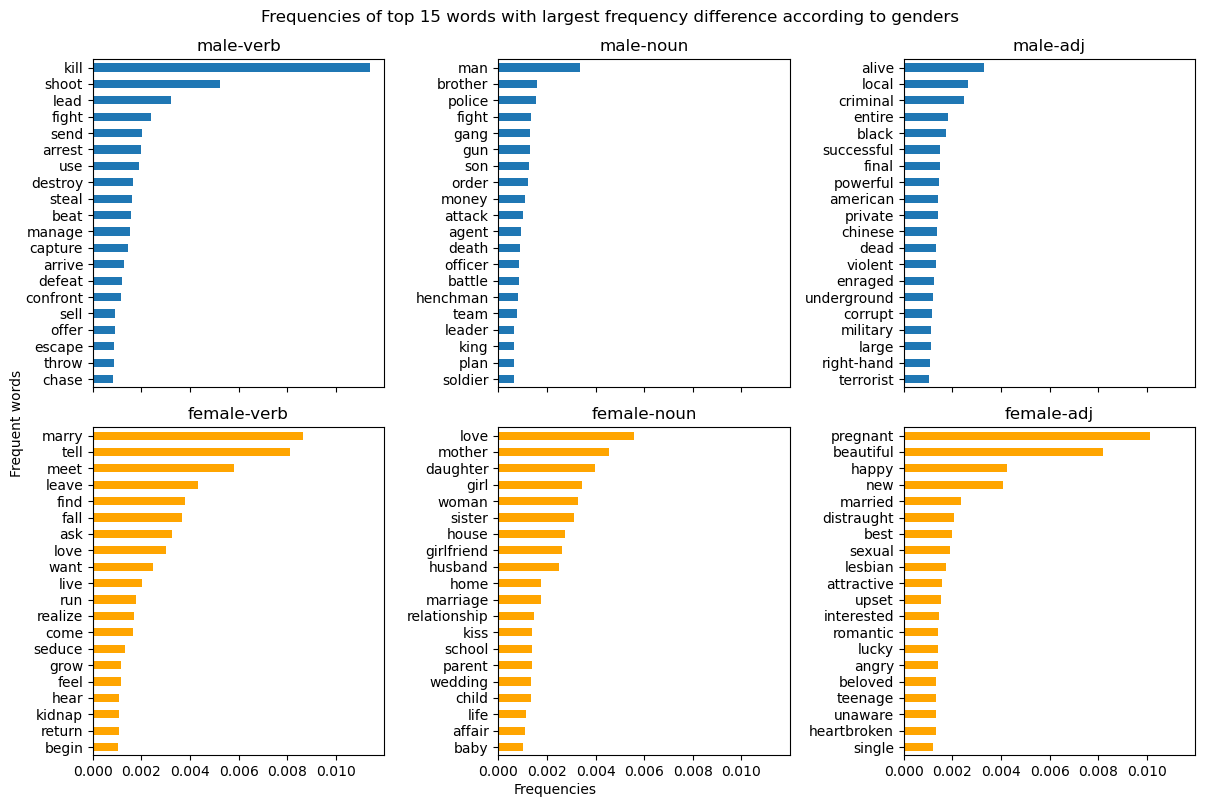

In [32]:
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(12, 8))
axes = axes.ravel()
fig.suptitle(
    "Frequencies of top 15 words with largest frequency difference according to genders"
)

for idx, word_type in enumerate(["verb", "noun", "adj"]):
    male_words = diff_dict[word_type].dropna().sort_values()[-20:]
    female_words = diff_dict[word_type].dropna().sort_values(ascending=False)[-20:].apply(np.abs)
    ax = male_words.plot.barh(
        ax=axes[idx], legend=False, title="male-{}".format(word_type)
    )
    ax = female_words.plot.barh(
        ax=axes[idx + 3],
        color="orange",
        legend=False,
        title="female-{}".format(word_type),
    )

fig.text(0.42, 0, "Frequencies")
fig.text(0, 0.4, "Frequent words", rotation=90)
plt.tight_layout()
plt.show()

We found that gender stereotypes do exist in movie plot summaries!

- From the first column of the figure, we can see word "kill" is more related to man characters while "love" and "marry" occur more with woman characters.
- From the second column of the figure, we can see word "police" appears in the top 15 frequent words of male characters but not in female characters.
- ~~From the last column of the figure, we can see word "old" shows up more than "young" for men but the trend is opposite to women.~~

We can roughly see that males are more related to the words "kill", "police", and "old" while females are associated with the words "love", "marry", and "young". This is a quite primitive analysis and somewhat subjective. We need to refine our analysis and find some methods and metrics in the future.